# MC mixer

Looking at data is a serious taboo at CMS so we try to build MC to look like the data.  Several MC samples are used to model the ttbar and Drell-Yan backgrounds and must be sampled in proportion to their cross-section for the sake of making data-like mixtures.


In [16]:
#imports
%cd '/home/naodell/work/CMS/amumu'
%matplotlib notebook

import os, sys
from timeit import default_timer as timer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nllfitter.plot_tools as pt

import matplotlib
pt.set_new_tdr()
matplotlib.rcParams['figure.figsize'] = (8,8)

/home/naodell/work/CMS/amumu


In [17]:
#configuration and data retrieval
datasets = [
            'ttbar_lep', 'ttbar_semilep', 
            'zjets_m-50',  'z1jets_m-50', 'z2jets_m-50', 
            'z3jets_m-50', 'z4jets_m-50', 
            'zjets_m-10to50', 'z1jets_m-10to50', 'z2jets_m-10to50',
            'z3jets_m-10to50', 'z4jets_m-10to50',
            ]
preselection = '(lepton1_pt > 25 and abs(lepton1_eta) < 2.1 \
                and lepton2_pt > 5 and abs(lepton2_eta) < 2.1 \
                and lepton1_q != lepton2_q \
                and 25 < dilepton_mass < 33) \
                and dilepton_pt_over_m > 2. \
                and ((n_bjets == 1 and n_jets == 0 and n_fwdjets == 1) \
                or (n_bjets >= 1 and n_bjets + n_jets == 2 and n_fwdjets == 0 \
                and met_mag < 40 and four_body_delta_phi > 2.5))'

dm_bg = pt.DataManager(input_dir     = 'data/flatuples/mumu_2012',
                       dataset_names = datasets,                       
                       selection     = 'mumu',
                       period        = 2012,
                       scale         = 19.8e3,
                       cuts          = preselection,
                       combine       = False
                    )


Loading dataframes: 100%|███████████████| 12.0/12.0 [00:07<00:00, 2.28it/s]
Loading dataframes: 100%|███████████████| 5.00/5.00 [00:02<00:00, 2.16it/s]


In order to prepare a sample from that datasets we have available, it will be important to know the contribution from each of those datasets taking into account their cross sections.  

In [18]:
# calculate proportions from each dataset
conditions    = ['preselection']
table_raw = dm_bg.print_yields(datasets, 
                               conditions = conditions, 
                               do_string  = False,
                               mc_scale   = False
                              )
table_scaled = dm_bg.print_yields(datasets, 
                                  conditions = conditions, 
                                  do_string  = False,
                                  mc_scale   = True
                                 )
table = pd.concat([table_raw, table_scaled], axis=1)
table.columns = ['raw', 'scaled']
table['scaling'] = table.raw/table.scaled
table

,raw,scaled,scaling
ttbar_lep,9731.0,416.454560,23.366295
ttbar_semilep,65.0,5.386560,12.067070
zjets_m-50,64.0,5.118264,12.504241
z1jets_m-50,36.0,19.263143,1.868854
z2jets_m-50,374.0,74.933413,4.991098
z3jets_m-50,300.0,33.816154,8.871500
z4jets_m-50,143.0,11.790590,12.128315
zjets_m-10to50,15.0,0.000000,inf
z1jets_m-10to50,6.0,3.794796,1.581112
z2jets_m-10to50,304.0,74.366694,4.087851


Based on the proportion in the *scaled* column, I prepare an admixture of the different background components.  I then take the first 44 $B'$ events for the signal component.

In [27]:
table.loc['background', 'scaled']
features = ['dilepton_mass', 'dilepton_pt', 'dilepton_pt_over_m', 'dilepton_b_mass', 'dilepton_j_mass', 'dijet_mass', 'met_mag']
background = []
for dataset in datasets:
    n_events = int(table.loc[dataset, 'scaled'])
    df = dm_bg.get_dataframe(dataset)
    irand = np.random.randint(0, df.shape[0], size=n_events)
    df = df.iloc[irand]
    data = df[features]
    data['sample_type'] = dm_bg._lut_datasets.loc[dataset].label
    background.append(data)
    
background = pd.concat(background)
signal = dm_ds.get_dataframe('bprime_xb')[features][:44]
signal['sample_type'] = 'bprime_xb'

To make sure the mixture is done properly, I compare the the background and background plus signal mixtures to the data.

<IPython.core.display.Javascript object>


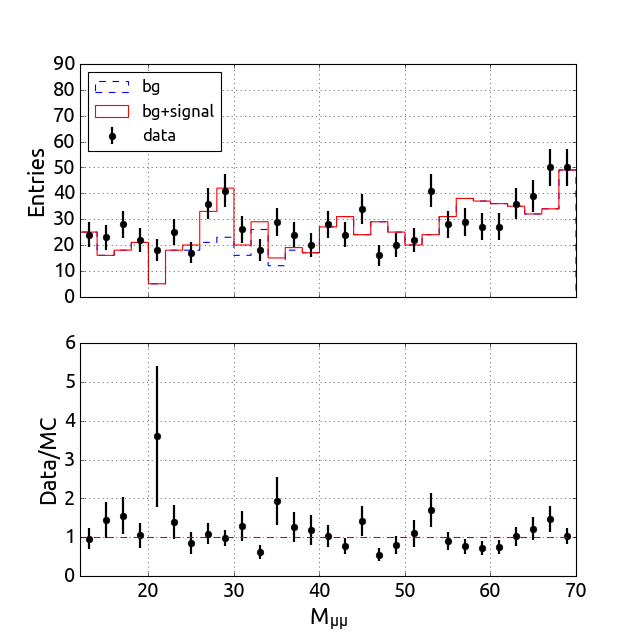

In [28]:
# Get data for validation and MC for mixing
data = dm_ds.get_dataframe('data')['dilepton_mass'].values
bg   = background['dilepton_mass'].values
sig  = signal['dilepton_mass'].values

# convert data to histogram with errorbars
x, y, yerr = pt.hist_to_errorbar(data,
                                 nbins = 29,
                                 xlim  = (12, 70)
                                ) 

# overlays
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
h_bg, b, _   = ax1.hist(bg, bins=29, range=(12, 70), histtype='step', linestyle='--', color='b')
h_sig, b, _  = ax1.hist(sig, bins=29, range=(12, 70), histtype='step', bottom=h_bg, color='r')
eb           = ax1.errorbar(x, y, yerr, fmt='ko', capsize=0, elinewidth=2)

ax1.legend(['bg', 'bg+signal', 'data'], loc=2, fontsize='small')
ax1.set_ylabel(r'Entries')
ax1.set_ylim(0, 90)
ax1.set_xlim(12, 70)
ax1.grid()

# ratio

ratio = y/(h_bg+h_sig)
ratio_err = pt.ratio_errors(y, h_bg+h_sig)
ax2.errorbar(x, ratio, ratio_err, fmt='ko', capsize=0, elinewidth=2)
ax2.plot([12, 70], [1, 1], 'r--')
ax2.set_xlabel(r'$\sf M_{\mu\mu}$')
ax2.grid()
ax2.set_ylabel(r'Data/MC')

fig.savefig('plots/mc_mix_validate.pdf')
plt.show()

The agreement looks quite good.  Time to combined the background and signal components, and write to disk.

In [29]:
sample = background.append(signal)
sample.to_csv('data/fit/dimuon_mc_mix.csv', index=False, sep=' ')